# Part 1 Preprocess
* * *

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

### Loading the datasets

Create a list of all files and add the corresponding city names and day type

In [3]:
data = [("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekdays.csv", "Amsterdam", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekdays.csv", "Athens","Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekdays.csv", "Barcelona", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekdays.csv", "Berlin", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekdays.csv", "Budapest", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekdays.csv", "Lisbon", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekdays.csv", "London", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekdays.csv", "Rome", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekdays.csv", "Paris", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekdays.csv", "Vienna", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekends.csv", "Amsterdam", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekends.csv", "Athens", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekends.csv", "Barcelona", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekends.csv", "Berlin", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekends.csv", "Budapest", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekends.csv", "Lisbon", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekends.csv", "London", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekends.csv", "Rome", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekends.csv", "Paris", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekends.csv", "Vienna", "Weekends")]
data = [("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekdays.csv", "Amsterdam", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekdays.csv", "Athens","Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekdays.csv", "Barcelona", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekdays.csv", "Berlin", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekdays.csv", "Budapest", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekdays.csv", "Lisbon", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekdays.csv", "London", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekdays.csv", "Rome", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekdays.csv", "Paris", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekdays.csv", "Vienna", "Weekdays"),
                 
                 ]


Merg data from all csv into one data frame 

In [4]:
dfs = []
for file_path, city_name, day_type in data:
    df = pd.read_csv(file_path, usecols=lambda col: col != 'Unnamed: 0')
    df = df.assign(city=city_name, type=day_type)
    dfs.append(df)
data = pd.concat(dfs)

The length and number of columns of the formed dataset

### Basic Inspection of the dataset

Get descriptive information about the dataset

In [5]:
numeric_colums= ["realSum", "person_capacity","cleanliness_rating","guest_satisfaction_overall",'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat']
categorical_colums= ["room_type","room_shared", "room_private", "host_is_superhost","multi", "biz" , 'city', 'type']

In [6]:
for i in categorical_colums:
    data[i] = data[i].astype('object')
    data[i].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

array([False, True], dtype=object)

array([True, False], dtype=object)

array([False, True], dtype=object)

array([1, 0], dtype=object)

array([0, 1], dtype=object)

array(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon',
       'London', 'Rome', 'Paris', 'Vienna'], dtype=object)

array(['Weekdays'], dtype=object)

View distributin of the value

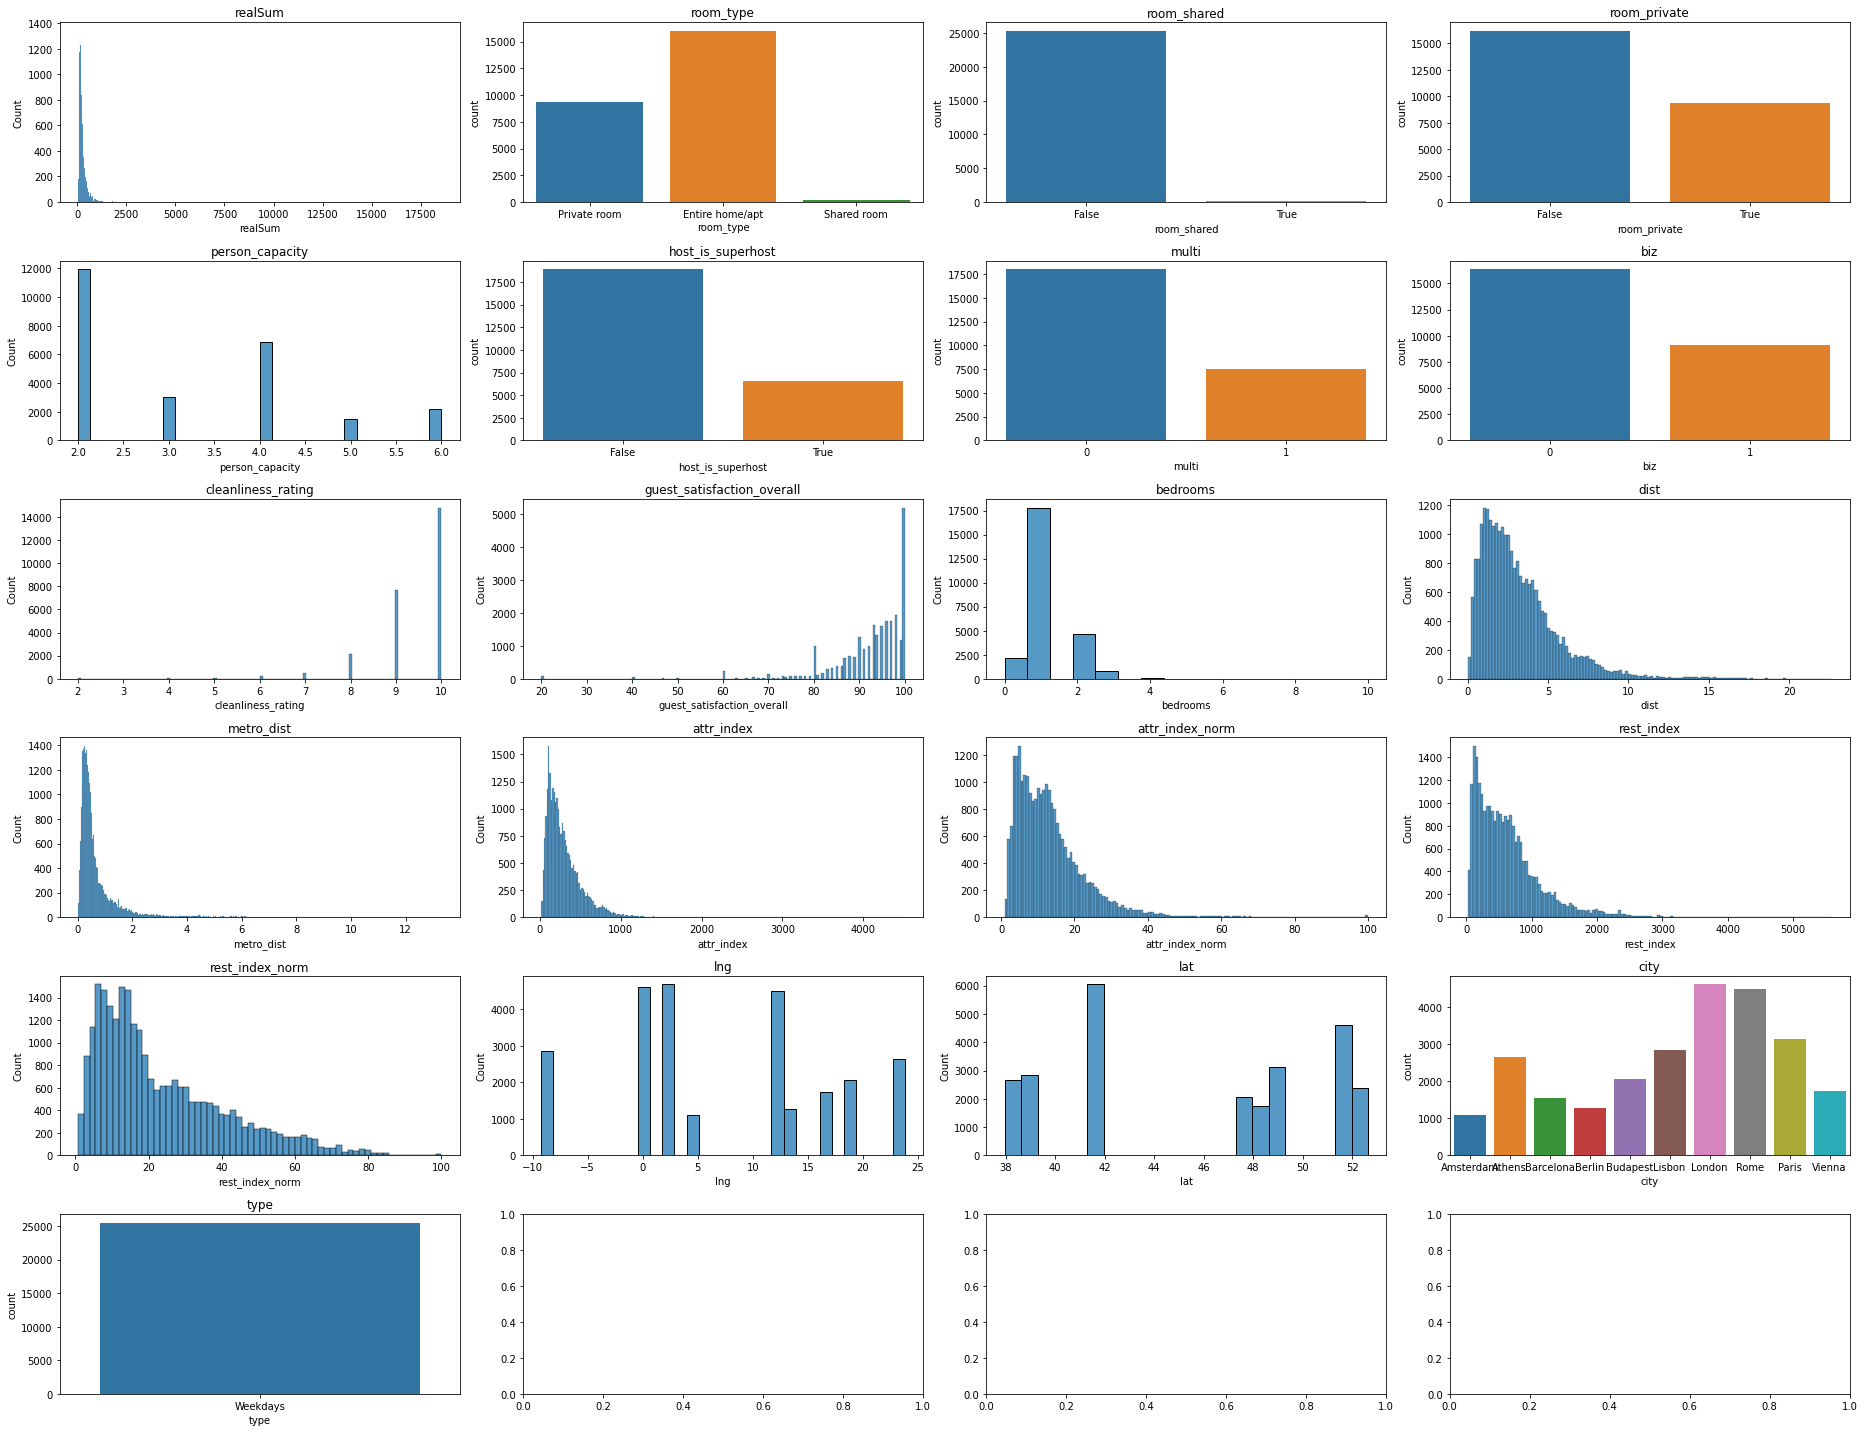

In [7]:
import seaborn as sns


fig, axes = plt.subplots(6,4,figsize=(26,20))

# We will not plot country because it has too many categories.
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

Latitude and longitude are values that can bring noise to the model.

In [8]:
data_clean=data
#data_clean=data_clean.drop(["lat","lng"], axis=1)

In [9]:
def combine_lat_long(lng, lat):
    latitude = np.radians(lat)
    longitude = np.radians(lng)

    amsterdam_latitude = np.radians(0)
    amsterdam_longitude = np.radians(0)

    # apply Haversine formula to compute distance
    latitude_distance = amsterdam_latitude - latitude
    longitude_distance = amsterdam_longitude - longitude
    a = np.sin(latitude_distance/2)**2 + np.cos(latitude) * np.cos(amsterdam_latitude) * np.sin(longitude_distance/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c

    return distance
#data_clean['distance'] = combine_lat_long(data_clean['lng'],data_clean['lat'])
#data_clean.drop(columns=['lng','lat'],inplace=True)

In [10]:
for i in  ['Amsterdam','Athens','Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome','Vienna']:
    data_clean["lat_"+i]=0
    data_clean["lng_"+i]=0

In [11]:
data_clean = data_clean.reset_index()

In [12]:
for ind in data_clean.index:
    data_clean['lat_'+data_clean['city'][ind]][ind]=data_clean['lat'][ind]
    data_clean['lng_'+data_clean['city'][ind]][ind]=data_clean['lng'][ind]


/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_9187/1713729126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['lat_'+data_clean['city'][ind]][ind]=data_clean['lat'][ind]
/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_9187/1713729126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['lng_'+data_clean['city'][ind]][ind]=data_clean['lng'][ind]
/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_9187/1713729126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [13]:
data_clean.drop(columns=['lng','lat'],inplace=True)

In [14]:
data_clean.columns

Index(['index', 'realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'city', 'type', 'lat_Amsterdam', 'lng_Amsterdam',
       'lat_Athens', 'lng_Athens', 'lat_Barcelona', 'lng_Barcelona',
       'lat_Berlin', 'lng_Berlin', 'lat_Budapest', 'lng_Budapest',
       'lat_Lisbon', 'lng_Lisbon', 'lat_London', 'lng_London', 'lat_Paris',
       'lng_Paris', 'lat_Rome', 'lng_Rome', 'lat_Vienna', 'lng_Vienna'],
      dtype='object')

### Resampling protocol


In [15]:
X = data_clean.loc[:,data_clean.columns != 'realSum']
y = data_clean['realSum']

In [16]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import  StandardScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats


In [17]:
numerical_colums=[
 'person_capacity',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'dist',
 'attr_index',
 'rest_index','lat_Athens', 'lng_Athens',
       'lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin',
       'lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon',
       'lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome',
       'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'lat_Amsterdam',
       'lng_Amsterdam']

In [18]:
for i in ["room_shared",	"room_private",	"host_is_superhost"]:
    X[i].replace([False, True],[0,1],inplace=True)

/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_9187/2627953380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i].replace([False, True],[0,1],inplace=True)


In [19]:
for column in [ "city", "type"]:
    X_one_hot = pd.get_dummies(X[column] , dtype=int, drop_first=False)
    X = pd.concat([X, X_one_hot], axis='columns')

# drop the values
X= X.drop(["room_type", "city", "type"], axis='columns')

In [58]:
new_columns=[ 
    'host_is_superhost',          
       'multi',
         'biz',  
         'guest_satisfaction_overall',
         'cleanliness_rating',
        'dist', 
        'metro_dist',
        'person_capacity',
        'bedrooms',
        'attr_index_norm',
        'rest_index_norm', 
       'room_shared',
         'room_private',
       'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London',
       'Paris', 'Rome', 'Vienna',
     #   'Weekends' ,
   #    'lat_Athens', 'lng_Athens','lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin','lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon','lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome', 'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'lat_Amsterdam',  'lng_Amsterdam'
 ]
X_new= X[new_columns]


In [59]:
X.columns

Index(['index', 'room_shared', 'room_private', 'person_capacity',
       'host_is_superhost', 'multi', 'biz', 'cleanliness_rating',
       'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
       'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm',
       'lat_Amsterdam', 'lng_Amsterdam', 'lat_Athens', 'lng_Athens',
       'lat_Barcelona', 'lng_Barcelona', 'lat_Berlin', 'lng_Berlin',
       'lat_Budapest', 'lng_Budapest', 'lat_Lisbon', 'lng_Lisbon',
       'lat_London', 'lng_London', 'lat_Paris', 'lng_Paris', 'lat_Rome',
       'lng_Rome', 'lat_Vienna', 'lng_Vienna', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome',
       'Vienna', 'Weekdays', 'realSum'],
      dtype='object')

In [60]:
numerical_colums_positive= [
'metro_dist']

In [61]:
prevdata=X
prevdata["realSum"]=y

In [62]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Assuming you have the 'prevdata' DataFrame
contamination = 0.05 
# Specify the columns on which you want to detect outliers
columns_to_check = prevdata.columns  # Replace with your actual column names

# Create a subset DataFrame with only the columns to check for outliers
subset_df = prevdata[columns_to_check]

# Create an IsolationForest model
isolation_forest = IsolationForest(contamination=contamination, random_state=42)

# Fit the IsolationForest model to the data
isolation_forest.fit(subset_df)

# Predict the outlier labels for each row
outlier_labels = isolation_forest.predict(subset_df)

# Filter the DataFrame to keep only non-outlier rows
filtered_df = prevdata[outlier_labels != -1]


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, random_state=42)

In [63]:

filtered_df = filtered_df.reset_index()

In [64]:
X_n = filtered_df.loc[:,filtered_df.columns != 'realSum']
y_n = filtered_df['realSum']

In [65]:
from sklearn.preprocessing import PowerTransformer


def categorical_preprocessing(X, y,scaler=None):
    print('Original shape:{}'.format(X.shape))
    X[numerical_colums_positive] = np.log(X[numerical_colums_positive] + 0.000001)
    print('New shape:{}'.format(X.shape))
    return X, y, scaler

X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.30, random_state=42,
                                                    stratify=X_n[[           
               
        'room_shared', 'room_private' , 'multi'
       ]])
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(16957, 48)
New shape:(16957, 48)
Original shape:(7268, 48)
New shape:(7268, 48)


In [66]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight

sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

#lr_one_hot = GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, random_state=0)
model = GradientBoostingRegressor(random_state=0)

y_train_t= np.log(y_train + 0.000001)
y_test_t= np.log(y_test + 0.000001)

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train_t, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train_t)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


# Predict on the test set and calculate metrics
y_pred =np.exp(y_pred) - 0.000001 
mse = mean_absolute_error(y_test, y_pred)
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absoute error on test set: ", msa)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  0.23004855194707105
R2 score using cross-validation:  0.6945085773187559


GradientBoostingRegressor(random_state=0)

Mean squared error on test set:  0.23297914055026367
R2 score on test set:  0.6845747393528882
Mean absoute error on test set:  68.25887818522509
Mean squared error on test set:  68.25887818522509
R2 score on test set:  0.20872907820245168


In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_absolute_error

sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

#lr_one_hot = GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, random_state=0)
model = GradientBoostingRegressor(random_state=0)

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absoute error on test set: ", msa)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  80.14739419993822
R2 score using cross-validation:  0.40636911644304413


GradientBoostingRegressor(random_state=0)

Mean absoute error on test set:  107.80565142574163
Mean squared error on test set:  107.80565142574163
R2 score on test set:  0.3466662695121816


In [61]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
#lr_one_hot = GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, random_state=0)

y_train_t= np.log(y_train + 0.000001)
y_test_t= np.log(y_test + 0.000001)

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train_t, cv=10, scoring='neg_mean_absolute_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train_t, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train_t, sample_weight=sample_weights_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test_t, y_pred)
r2 = r2_score(y_test_t, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


# Predict on the test set and calculate metrics
y_pred =np.exp(y_pred) - 0.000001 
mse = mean_absolute_error(y_test, y_pred)
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absoute error on test set: ", msa)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  0.2522026068769293
R2 score using cross-validation:  0.6700630713841995


LinearRegression()

Mean squared error on test set:  0.2795405068328783
R2 score on test set:  0.6321497117236616
Mean absoute error on test set:  85.49187873318148
Mean squared error on test set:  85.49187873318148
R2 score on test set:  0.3182960420933221


In [62]:
len(y_test)

15513

In [63]:
from sklearn.linear_model import RidgeCV

lr_one_hot = RidgeCV()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_absolute_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))


# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

RidgeCV()

Train MSE score: 0.22817942453972573
Cross-Validation MSE score: 99.92477962459631
Cross-Validation R2 score: 0.22817942453972573
Mean squared error on test set:  101.62936555648417
R2 score on test set:  0.25716346651655186


In [64]:
from sklearn.linear_model import LassoCV

lr_one_hot = LassoCV()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_absolute_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e+06, tolerance: 3.973e+05
  model = cd_fast.enet_coordinate_descent(


LassoCV()

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+07, tolerance: 3.276e+05
  model = cd_fast.enet_coordinate_descent(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e+07, tolerance: 3.211e+05
  model = cd_fast.enet_coordinate_descent(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

Train MSE score: 0.22359666573914472
Cross-Validation MSE score: 100.59827136663826


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+07, tolerance: 3.276e+05
  model = cd_fast.enet_coordinate_descent(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e+07, tolerance: 3.211e+05
  model = cd_fast.enet_coordinate_descent(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

Cross-Validation R2 score: 0.22359666573914472
Mean squared error on test set:  102.37547171428534
R2 score on test set:  0.25054252420070466


In [65]:
from sklearn.neural_network import MLPRegressor

lr_one_hot = MLPRegressor()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = - cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='neg_mean_absolute_error')
cv_mse = r2_lr_one_hot_cv.mean()

print('Train MSE score: {}\nCross-Validation MSE score: {}'.format(r2_lr_one_hot_train, cv_mse))

r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Cross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

# Predict on the test set and calculate metrics
y_pred = lr_one_hot.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
